<h1>Projket staż M-bank 2021</h1>
<h2>Mateusz Jakubczak</h2>


In [1]:
# visualizatin 
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import phik
from scipy import stats
import math
from pandas_profiling import ProfileReport
import statsmodels.stats.weightstats as st 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
from IPython.display import Image


%matplotlib inline

### Pierwsze co należy zrobić w analizie to przygotować dane.


In [2]:
df =pd.read_csv("BankChurners.csv")
display(df.head())

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

## Mamy dwie zmienne, które, patrząc na ich nazwę, są wynikiem innych modeli.
Ponieważ nie znamy parametrów tych modeli poza tym jakie zmienne zostały w nich wykorzystane nie możemy użyć tych zmiennych, jak i nie ma ich w specyfikacji samego zadania, dlatego pozbywamy się tych zmiennych. Wyrzucamy równiez zmienną CLIENTNUM, która stanowi tylko index dla naszych danych. 

In [3]:
df = df.drop(["Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1","CLIENTNUM"],
             axis = 1)

Mamy parę niezgodnych typów kategorycznych rozpoznanych jako typ "string". Poprawiamy to.

In [4]:
df = df.convert_dtypes()

In [5]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  string 
 1   Customer_Age              10127 non-null  Int64  
 2   Gender                    10127 non-null  string 
 3   Dependent_count           10127 non-null  Int64  
 4   Education_Level           10127 non-null  string 
 5   Marital_Status            10127 non-null  string 
 6   Income_Category           10127 non-null  string 
 7   Card_Category             10127 non-null  string 
 8   Months_on_book            10127 non-null  Int64  
 9   Total_Relationship_Count  10127 non-null  Int64  
 10  Months_Inactive_12_mon    10127 non-null  Int64  
 11  Contacts_Count_12_mon     10127 non-null  Int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  Int64  
 14  Avg_Op

None

Sprawdzamy czy są duplikaty oraz puste warotści.

In [6]:

display(pd.DataFrame([df.duplicated().sum()],columns=["Liczba duplikatów"]).style.hide_index())

Dane są czyste i możemy z nimi pracować.

# Wizualizacja danych

In [7]:
#profile = ProfileReport(df, config_file="config.yml")


In [8]:
#profile.to_notebook_iframe()


## Wnioski z eksploracji:

1. Mamy podejrzanie dużą liczbę rachunków, które mają daokładnie 3 lata (36 miesięcy) od momentu założenia konta.
2. Wartości typu NaN są nie prawidłowo zakwalifkowane jako "Unknow".
3. Nasza zmienna endogeniczna jest niezbalansowana.
4. Mamy podejrzanie wysoką liczbę klientów z wiekiem około 48 lat.
5. Zmienna Card_Category jest wysoce niezbalansaowana, 20 platynowych kart do 9.5 tyś niebieskich.
6. Credit limit posiada dystrybucję z grubym ogonem.
7. Większość zmiennych nie przyjmuje rozkładu normalnego.

## Sprawdźmy korelacje naszej  zmiennej endogenicznej
Poniższa kolumna przedstawia korelacje typu phik, im warość jest bliższa 1, tym bardziej skorelowane ze sobą są dwie wartości. 

In [9]:
# popraw na zmienne kategoryczne 
for c in ["Attrition_Flag","Gender","Education_Level","Marital_Status","Income_Category","Card_Category"]:
    df[c] = df[c].replace("Unknown",np.nan,method="pad")
    df[c] = df[c].astype("category")


In [10]:
# Ustawienie zmiennych na typu float
for c in df.columns:
    if df[c].dtype.__str__() == "Int64":
        df[c] = df[c].astype("float64")

In [11]:
display(df.isna().sum().to_frame("Ilośc NA"))

Ilośc NA
Attrition_Flag                   0
Customer_Age                     0
Gender                           0
Dependent_count                  0
Education_Level               1519
Marital_Status                 749
Income_Category               1112
Card_Category                    0
Months_on_book                   0
Total_Relationship_Count         0
Months_Inactive_12_mon           0
Contacts_Count_12_mon            0
Credit_Limit                     0
Total_Revolving_Bal              0
Avg_Open_To_Buy                  0
Total_Amt_Chng_Q4_Q1             0
Total_Trans_Amt                  0
Total_Trans_Ct                   0
Total_Ct_Chng_Q4_Q1              0
Avg_Utilization_Ratio            0

### Mamy parę wartości typu NA w zmiennych kategorycznych. W dalszej części analizy zdecydujemy co z nimi zrobimy, bo może się okazać że nie wykorzystamy tych zmiennych do dalszej analizy. 

In [12]:
corr = df.phik_matrix()
display(corr["Attrition_Flag"].sort_values(ascending = False).to_frame())

interval columns not set, guessing: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


Attrition_Flag
Attrition_Flag                  1.000000
Total_Trans_Ct                  0.592470
Total_Revolving_Bal             0.522422
Total_Trans_Amt                 0.423372
Total_Ct_Chng_Q4_Q1             0.409053
Avg_Utilization_Ratio           0.314541
Total_Relationship_Count        0.230833
Contacts_Count_12_mon           0.223812
Total_Amt_Chng_Q4_Q1            0.184180
Months_Inactive_12_mon          0.183537
Gender                          0.055962
Education_Level                 0.039007
Customer_Age                    0.031183
Dependent_count                 0.029239
Credit_Limit                    0.028030
Months_on_book                  0.025403
Avg_Open_To_Buy                 0.025286
Income_Category                 0.024901
Marital_Status                  0.011258
Card_Category                   0.000000

### Wnioski z korelacji:
1. Mamy wysoką korelację z ilością wykonanych tranzakcji a zmienną endogeniczną.
2. Zmienne z NA mają bardzo niską korelację ze zmienną endogeniczną.

# Badanie hipotez:
1. Posiadacze wyższej klasy karty mają mniejszą szansę na zamknięcie konta.
2. Posiadacze konta wykonujący dużo tranzakcji mają mniejszą szansę na zamknięcie konta. 
3. Osoby posiadające konto przez długi czas mają mniejszą szansę na zamknięcie konta.

# Hipoteza 1

In [13]:
#Hipoteza 1 
df.Card_Category.value_counts()
df_h1 = df.Card_Category == "Blue"
df_h1_prem = df.Card_Category == "Platinum"

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64

In [14]:
df["Attrition_Flag_onehot"] = pd.get_dummies(df["Attrition_Flag"]).iloc[:,0]

df[["Attrition_Flag","Attrition_Flag_onehot"]].head()

Attrition_Flag  Attrition_Flag_onehot
0  Existing Customer                      0
1  Existing Customer                      0
2  Existing Customer                      0
3  Existing Customer                      0
4  Existing Customer                      0

## Z one hot encodingu wynika, że obecny konsument ma przypisane "0", natomiast konsument z zamkniętym kontem ma przypisaną wartość "1" .

In [15]:
prob_blue = df[df_h1]["Attrition_Flag"].value_counts()
d_blue = {
"Prawdobieństwo odejścia":prob_blue.iloc[1] / prob_blue.iloc[0],
 "Liczebność populacji":prob_blue.iloc[1] + prob_blue.iloc[0]
}
display(pd.DataFrame.from_dict(d_blue,orient='index'))

0
Prawdobieństwo odejścia     0.191866
Liczebność populacji     9436.000000

In [16]:
prob_rest = df[~df_h1]["Attrition_Flag"].value_counts()
d_rest = {
"Prawdobieństwo odejścia":prob_rest.iloc[1] / prob_rest.iloc[0],
 "Liczebność populacji":prob_rest.iloc[1] + prob_rest.iloc[0]
}
display(pd.DataFrame.from_dict(d_rest,orient='index'))

0
Prawdobieństwo odejścia    0.185249
Liczebność populacji     691.000000

In [17]:

display(pd.DataFrame.from_dict({
    "P-value dla t testu, porównanie między 'Blue' a 'Platinum' klasą karty":
st.ttest_ind(df[df_h1_prem]["Attrition_Flag_onehot"],df[df_h1]["Attrition_Flag_onehot"], 
             alternative="larger")[1]
}, orient='index'))

0
P-value dla t testu, porównanie między 'Blue' a...  0.139738

In [18]:

display(pd.DataFrame.from_dict({
    "P-value dla t testu, porównanie między 'Blue' a pozostałymi klasami kart":
st.ttest_ind(df[~df_h1]["Attrition_Flag_onehot"],df[df_h1]["Attrition_Flag_onehot"], alternative="larger")[1]
}, orient='index'))

0
P-value dla t testu, porównanie między 'Blue' a...  0.626887

### Możemy odrzucić hipotezę, że klasa karty wpływa na szansę zamknięcia konta.

# Hipoteza 2  
Zakładamy, że osoby wykonujące dużo tranzakcji znajdują się w 90 percentylu wykonanych tranzakcji(Wartość percentyla należało by wyestymować budując modela, ale to odbędzie się w dalszych krokach analizy). 

### Ponieważ sama liczba trazakcji niewiele nam mówi i jest obciążona poprzez wartość tych trazakcji, do analityki stworzymy zmienną opisującą średnią wartość tranzakcji. Sprawdźmy czy taka zmienna lepiej koreluje ze zmienną endogeniczną. 

In [19]:
df["Avg_Trans_Amt"] = df.Total_Trans_Amt/df.Total_Trans_Ct


In [20]:

corr = df[["Attrition_Flag_onehot","Total_Trans_Ct","Avg_Trans_Amt","Total_Trans_Amt"]].corr(method='kendall')
display(corr["Attrition_Flag_onehot"].to_frame())

Attrition_Flag_onehot
Attrition_Flag_onehot               1.000000
Total_Trans_Ct                     -0.309061
Avg_Trans_Amt                      -0.005430
Total_Trans_Amt                    -0.182744

 Zmienna ta koreluje o wiele gorzej niż odzielnie liczba tranzakcji oraz wartość tranzakcji. Wybieramy do dalszej analizy liczby przeprowadzonych tranzakcji oraz porzucamy stworzoną zmienną. 


In [21]:
q_90 = df.Total_Trans_Ct.quantile(0.9)

display(pd.DataFrame([q_90],columns=["Wartość 90 percentyla"]).style.hide_index())


In [22]:
df_h2 =  df.Total_Trans_Ct >= q_90

In [23]:
prob_above_q90 = df[df_h2]["Attrition_Flag"].value_counts()
d_above = {
"Prawdobieństwo odejścia":prob_above_q90.iloc[1] / prob_above_q90.iloc[0],
 "Liczebność populacji":prob_above_q90.iloc[1] + prob_above_q90.iloc[0]
}
display(pd.DataFrame.from_dict(d_above,orient='index'))

0
Prawdobieństwo odejścia     0.00095
Liczebność populacji     1054.00000

In [24]:
prob_bellow_q90 = df[~df_h2]["Attrition_Flag"].value_counts()
d_bellow = {
"Prawdobieństwo odejścia":prob_bellow_q90.iloc[1] / prob_bellow_q90.iloc[0],
 "Liczebność populacji":prob_bellow_q90.iloc[1] + prob_bellow_q90.iloc[0]
}
display(pd.DataFrame.from_dict(d_bellow,orient='index'))

0
Prawdobieństwo odejścia     0.218343
Liczebność populacji     9073.000000

In [25]:
display(pd.DataFrame.from_dict({
    "P-value dla t testu, porównanie miedzy większymi od 90 percentyla, a resztą":
st.ttest_ind(df[~df_h2]["Attrition_Flag_onehot"],df[df_h2]["Attrition_Flag_onehot"],
             alternative="larger")[1]
}, orient='index'))

0
P-value dla t testu, porównanie miedzy większym...  3.747446e-51

### P-value jest równe 0,
co daje nam pewność o odrzuceniu $H_0$ dla t testu. Prawdopodobieństwo odejścia jest zdecydowanie niższe dla osób wykonujących dużo tranzakcji. 

### Sprawdźmy jeszcze hipotezę - Czy wykonywanie małej liczby tranzakcji zwiększa szanse na odejście?

In [26]:
q_10 = df.Total_Trans_Ct.quantile(0.1)

display(pd.DataFrame([q_10],columns=["Wartość 10 percentyla"]).style.hide_index())


In [27]:
df_h2_1 =  df.Total_Trans_Ct <= q_10

In [28]:
prob_bellow_q10 = df[df_h2_1]["Attrition_Flag"].value_counts()
d_above = {
"Prawdobieństwo odejścia":prob_bellow_q10.iloc[1] / prob_bellow_q10.iloc[0],
 "Liczebność populacji":prob_bellow_q10.iloc[1] + prob_bellow_q10.iloc[0]
}
display(pd.DataFrame.from_dict(d_above,orient='index'))

0
Prawdobieństwo odejścia     0.362784
Liczebność populacji     1018.000000

In [29]:
prob_above_q10 = df[~df_h2_1]["Attrition_Flag"].value_counts()
d_bellow = {
"Prawdobieństwo odejścia":prob_above_q10.iloc[1] / prob_above_q10.iloc[0],
 "Liczebność populacji":prob_above_q10.iloc[1] + prob_above_q10.iloc[0]
}
display(pd.DataFrame.from_dict(d_bellow,orient='index'))

0
Prawdobieństwo odejścia     0.1749
Liczebność populacji     9109.0000

In [30]:
display(pd.DataFrame.from_dict({
    "P-value dla t testu, porównanie miedzy większymi od 10 percentyla, a resztą":
st.ttest_ind(df[~df_h2_1]["Attrition_Flag_onehot"],df[df_h2_1]["Attrition_Flag_onehot"],
             alternative="smaller")[1]
}, orient='index'))

0
P-value dla t testu, porównanie miedzy większym...  1.648878e-22

### P-value jest znów równe 0, co oznacza że odrzucamy  $H_0$ dla t testu i możemy powiedzieć, że : 
 Im więcej tranzakcji wykonuje dana osoba tym mniejsza jest jej szansa na odejście. 

# Hipoteza 3 
### Osoby posiadające konto przez długi czas mają mniejszą szansę na zamknięcie konta.
Robimy takie same założenia jak testując wcześniejsze hipotezy.

In [31]:
df.Months_on_book.describe()

count    10127.000000
mean        35.928409
std          7.986416
min         13.000000
25%         31.000000
50%         36.000000
75%         40.000000
max         56.000000
Name: Months_on_book, dtype: float64

In [32]:
q_90 = df.Months_on_book.quantile(0.9)

display(pd.DataFrame([q_90],columns=["Wartość 90 percentyla"]).style.hide_index())

df_h3 = df.Months_on_book >= q_90

In [33]:
prob_above_q90 = df[df_h3]["Attrition_Flag"].value_counts()
d_above = {
"Prawdobieństwo odejścia":prob_above_q90.iloc[1] / prob_above_q90.iloc[0],
 "Liczebnosc populacji":prob_above_q90.iloc[1] + prob_above_q90.iloc[0]
}
display(pd.DataFrame.from_dict(d_above,orient='index'))

0
Prawdobieństwo odejścia     0.200608
Liczebnosc populacji     1185.000000

In [34]:
prob_bellow_q90 = df[~df_h3]["Attrition_Flag"].value_counts()
d_above = {
"Prawdobieństwo odejścia":prob_bellow_q90.iloc[1] / prob_bellow_q90.iloc[0],
 "Liczebność populacji":prob_bellow_q90.iloc[1] + prob_bellow_q90.iloc[0]
}
display(pd.DataFrame.from_dict(d_above,orient='index'))

0
Prawdobieństwo odejścia     0.190204
Liczebność populacji     8942.000000

In [35]:
display(pd.DataFrame.from_dict({
    "P-value dla t testu, porównanie miedzy większymi od 90 percentyla, a resztą":
st.ttest_ind(df[~df_h3]["Attrition_Flag_onehot"],df[df_h3]["Attrition_Flag_onehot"],
             alternative="larger")[1]
}, orient='index'))

0
P-value dla t testu, porównanie miedzy większym...  0.739332

### P-vale jest wysokie, nie odrzucamy  $H_0$ dla t testu, co oznacza, że długość korzystania z usług banku przez klienta nie wpływa znacząco na jego szansę odejścia.

### Wizualne zbadanie interakcji
Przed zakończeniem analizy zbadajmy jeszcze wizualnie jak zachowują się nasze zmienne, patrząc na róznice wizualne w parach wykresów wielu zmiennych. 



In [36]:
df.columns


Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Attrition_Flag_onehot', 'Avg_Trans_Amt'],
      dtype='object')

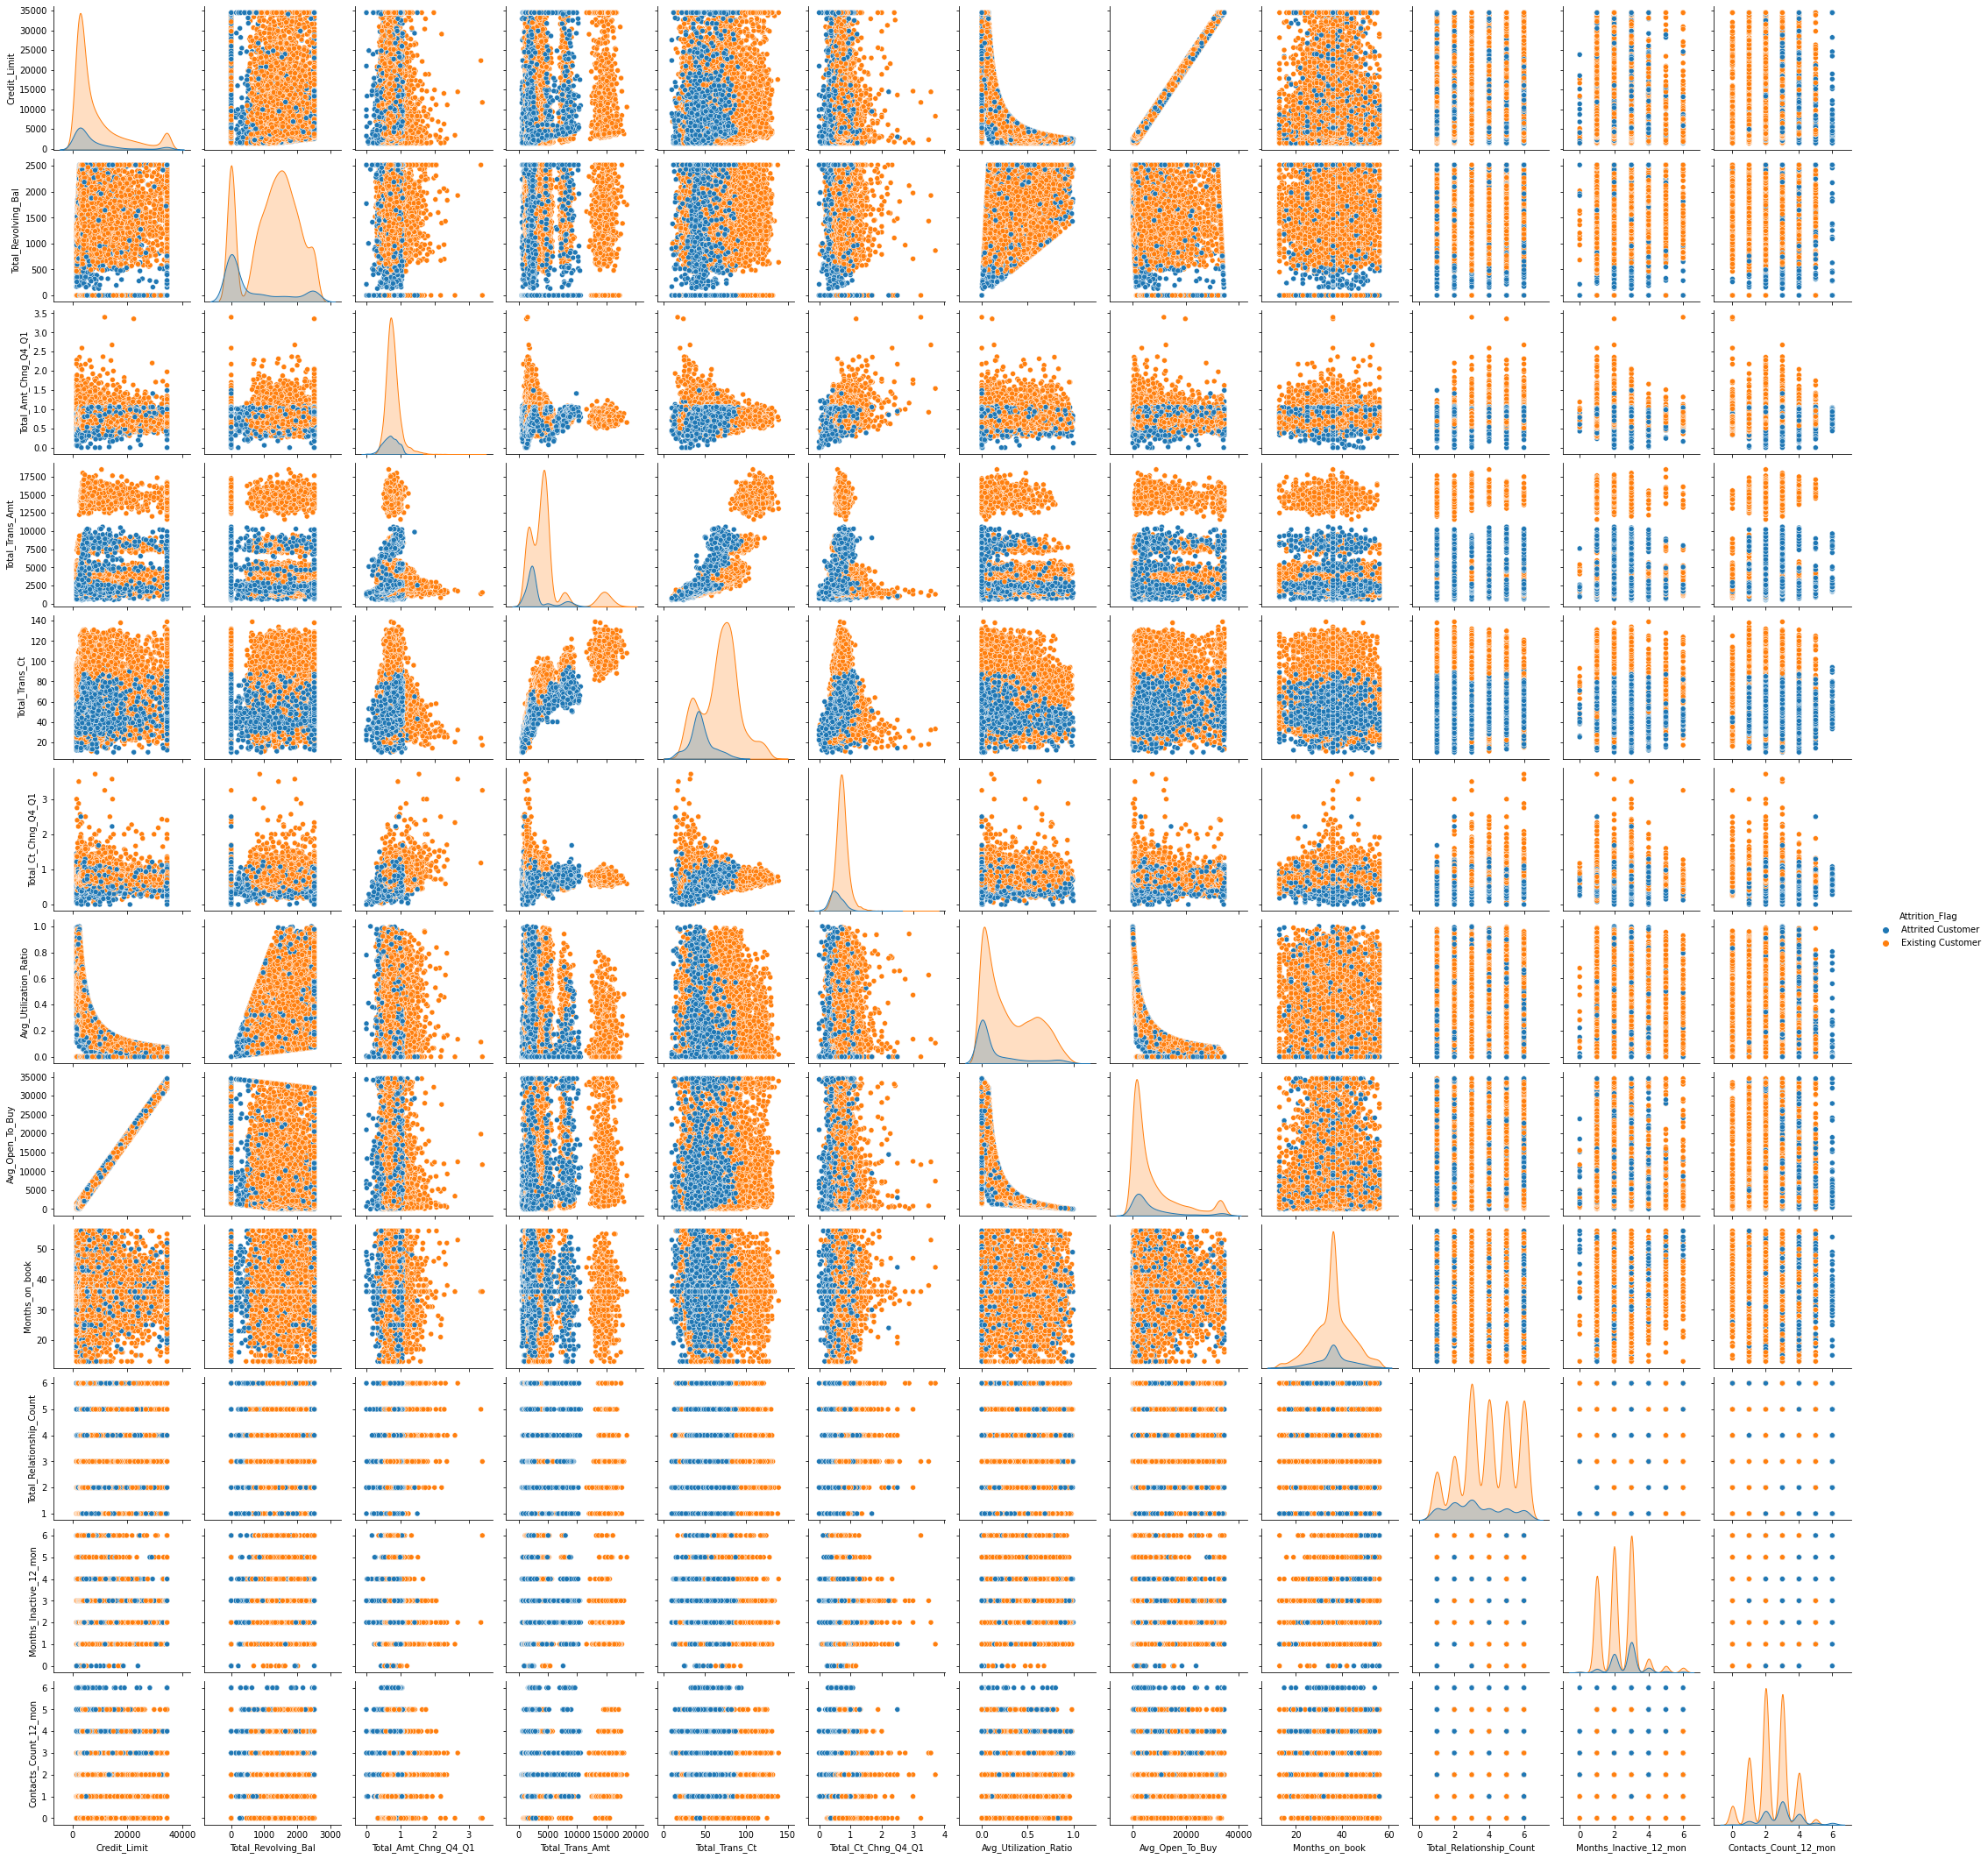

In [37]:
sns.pairplot(df[["Attrition_Flag",
                 "Credit_Limit", 
                 "Total_Revolving_Bal", 
                 "Total_Amt_Chng_Q4_Q1", 
                 "Total_Trans_Amt", 
                  "Total_Trans_Ct",
                 "Total_Ct_Chng_Q4_Q1", 
                "Avg_Utilization_Ratio",
                 "Avg_Open_To_Buy",
                 "Months_on_book",
                  'Total_Relationship_Count',
                 'Months_Inactive_12_mon',
                 'Contacts_Count_12_mon',
                ]],
             hue = "Attrition_Flag"
            )

### Interesujące wyniki analizy wizualnej:
1. Całkowita wartość tranzakcji zachowuje się podobnie (im większa wartość, tym mniejsza szansa odejścia klienta) co całkowita liczba tranzakcji.
2. Niska wartość dla "Total_Amt_Chng_Q4_Q1" sygnalizuje możliwość odejćia klienta. W ten sam sposób zachowuje się "Total_Ct_Chng_Q4_Q1".
3. Niska wartość utylizacji karty również sugeruje możliwość odejścia klienta.
4. Wysoka liczba kontaktów z klientem sygnalizuje 
5. Niska liczba relacji z klientem sygnalizuje możliwość odejścia.
6. Niska wartość "Total_Revolving_Bal" sygnalizuje możliwość odejścia.

In [56]:
df.Contacts_Count_12_mon.value_counts()

3.0    3380
2.0    3227
1.0    1499
4.0    1392
0.0     399
5.0     176
6.0      54
Name: Contacts_Count_12_mon, dtype: int64

In [71]:
# anliza odejścia klienta po dużej liczbie kontaktów 
for i in range(0,7):
    df_contact = df.Contacts_Count_12_mon == i
    prob = df[df_contact]["Attrition_Flag"].value_counts()
    d_above = {
    "Prawdobieństwo odejścia":prob.iloc[1] / prob.iloc[0],
     "Liczebnosc populacji":prob.iloc[1] + prob.iloc[0]
    }
    display(pd.DataFrame.from_dict(d_above,orient='index', columns=[f"liczba kontaktów {i}"]))

liczba kontaktów 0
Prawdobieństwo odejścia            0.017857
Liczebnosc populacji             399.000000

liczba kontaktów 1
Prawdobieństwo odejścia            0.077642
Liczebnosc populacji            1499.000000

liczba kontaktów 2
Prawdobieństwo odejścia            0.142705
Liczebnosc populacji            3227.000000

liczba kontaktów 3
Prawdobieństwo odejścia            0.252316
Liczebnosc populacji            3380.000000

liczba kontaktów 4
Prawdobieństwo odejścia            0.292479
Liczebnosc populacji            1392.000000

liczba kontaktów 5
Prawdobieństwo odejścia            0.504274
Liczebnosc populacji             176.000000

liczba kontaktów 6
Prawdobieństwo odejścia                 0.0
Liczebnosc populacji                   54.0

Dla bardzo wysokiej liczby kontaktów z klientem oraz bardzo niskiej jego szansa na odejście jest niska.

### Po przeprowadzeniu wstępnej analizy przechodzimy do modelowania

# Modelowanie 

### Z analizy wiemy, które zmienne są interesujące i sugerują jakich modeli możemy użyć. Ważne jest, aby wybrać model, który jest odporny na niezbalansowane dane lub użyć metody do samplowania z danych terningowych z zachowaniem balansu w danych. 

### Należy sobie teraz zadać pytanie, czego oczekujemy od modelu, żeby model był interpretowalny czy, żeby zwracał jak najlepsze wyniki.  Mamy tutaj trade-off wyjaśnialny model nie będzie miał dużej precyzji czy celności natomiast model z dużą precyzją i celnością może być nie do zintepretowania. Biorąc pod uwagę to oraz wcześniejsza analizę stworzymy wybrane modele: 

1. Drzewo decyzyjne 
2. Regresją logistyczną 
3. Naive bayes

### Pierwszy krok to podział danych na testowy i treningowy 

In [38]:

# niezbalansowane dane 
from imblearn.over_sampling import SMOTE
#metryki 
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

from sklearn import model_selection
# podiział an test-train 
from sklearn.model_selection import train_test_split
# modele
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

 ### Został wybrany tylko podzbiór zmiennych, które wyglądały na interesujące w procesie analizy. 

In [39]:
selected_columns = [
                 "Total_Revolving_Bal", 
                 "Total_Amt_Chng_Q4_Q1", 
                 "Total_Trans_Amt", 
                  "Total_Trans_Ct",
                 "Total_Ct_Chng_Q4_Q1", 
                "Avg_Utilization_Ratio",
                  'Total_Relationship_Count',
                 'Contacts_Count_12_mon',
                ]


In [40]:

# oversampling do zbalansowania danych 
sm = SMOTE()

X, y = sm.fit_resample(df[selected_columns], df["Attrition_Flag_onehot"])


X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

print(f"Balans zmiennych PRZED oversamplingu  {(df['Attrition_Flag_onehot'] == 1).sum()/(df['Attrition_Flag_onehot'] == 0).sum()} ")
print(f"Balans zmiennych PO oversamplingu  {(y == 0).sum()/(y == 1).sum()} ")

Balans zmiennych PRZED oversamplingu  0.19141176470588236 
Balans zmiennych PO oversamplingu  1.0 


## Drzewo decyzyjne

In [41]:
clf_max3 = DecisionTreeClassifier(max_depth = 3)

clf_max3.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3)

In [42]:

export_graphviz(clf_max3, out_file="tree.dot", class_names=["Otwarte konto", "Zamknięte konto"],feature_names= X.columns, impurity=False, filled=True)

!dot -Tpng tree.dot -o tree_limited.png -Gdpi=1200

Image(filename = "tree_limited.png")


Interpretacja drzewa polaga na przejściu przez drzewo sprawdzając podane warunki. Im mocniejszy kolor, tym większą pewność mamy o poprawnym przewidzeniu. 
### Interpretacja wyników:
1. Całkowita liczba tranzakcji okazała się najbardziej znaczącą zmienną
2. Jeśli mamy niską liczbę tranzakcji oraz obrotów to liczba poroduktów posiadanych przez klienta dobrze pozwala nam określić prawdopodobieństwo zamknięcia konta. 
3. Idąc po gałęzi najbardziej na lewo widzimi bardzo dobrą klasyfikację dla klienta nieaktywnego z dużym prawdopodobieństwem odejścia i odwrotną sytuację, gdy idziemy gałęzią najbardziej w prawo. 

In [43]:
pred_dtc = clf_max3.predict(X_test)
conf_dec_tree = confusion_matrix(y_test,pred_dtc )

display(pd.DataFrame(conf_dec_tree,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )

score_desion_max3_balanced = pd.DataFrame(
[accuracy_score(y_test,pred_dtc),
f1_score(y_test,pred_dtc)
],index= ["Accuracy", "f1_score"], columns=["Drzewo decyzjne o głebokości 3"]
)
display(score_desion_max3_balanced)


Predicted True  Prediced False
Acucal True            1592              84
Acual False             381            1343

Drzewo decyzjne o głebokości 3
Accuracy                        0.863235
f1_score                        0.852428

In [44]:
clf_balanced = DecisionTreeClassifier()

clf_balanced.fit(X_train, y_train)
pred_dtc = clf_balanced.predict(X_test)
conf_dec_tree_balanced = confusion_matrix(y_test,pred_dtc )

display(pd.DataFrame(conf_dec_tree_balanced,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )


score_decison_balanced = pd.DataFrame(
[accuracy_score(y_test,pred_dtc),
f1_score(y_test,pred_dtc)
],index= ["Accuracy", "f1_score"], columns=[f"Drzewo decyzjne o głebokości {clf_balanced.get_depth()} "]
)
display(score_decison_balanced)


DecisionTreeClassifier()

Predicted True  Prediced False
Acucal True            1591              85
Acual False              84            1640

Drzewo decyzjne o głebokości 21 
Accuracy                          0.950294
f1_score                          0.951000

### Eksperyment na niezbalansowanych danych 

In [45]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(df[selected_columns], df["Attrition_Flag_onehot"] , test_size=0.2, random_state=42)


clf_unbalanced = DecisionTreeClassifier()

clf_unbalanced.fit(X_train_u, y_train_u)


pred_dtc_u = clf_unbalanced.predict(X_test_u)
conf_dec_tree = confusion_matrix(y_test_u,pred_dtc_u )

display(pd.DataFrame(conf_dec_tree,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )


score_deison_unbalanced = pd.DataFrame(
[accuracy_score(y_test_u,pred_dtc_u),
f1_score(y_test_u,pred_dtc_u)
],index= ["Accuracy", "f1_score"], columns=[f"Drzewo decyzjne o głebokości {clf_unbalanced.get_depth()} "]
)
display(score_deison_unbalanced)


DecisionTreeClassifier()

Predicted True  Prediced False
Acucal True            1625              74
Acual False              63             264

Drzewo decyzjne o głebokości 19 
Accuracy                          0.932379
f1_score                          0.793985

## Wnioski z modelu: 
1. Model, który jest prosty nie ma tak dobrych metryk jak model bardziej skomplikowany, ale jest wyjaśnialny. 
2. Oversampling danych znacząco polepsza wyniki modelu i usuwa 'baias' na bardziej popularną klasę, co widzimy po spadku f1_score, przy porównaniu modeli na zbalansownaych i niezbalansowanych danych. 
3. Analiza dużego modelu jest możliwa, jednak jest ona dosyć skomplikowana ze wzgledu na dużą wielkość drzewa decyzyjnego.


## Regresja logistyczna

In [46]:
logit_model = LogisticRegression().fit(X_train,y_train)

logit_pred = logit_model.predict(X_test)

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:



conf_logit = confusion_matrix(y_test,logit_pred )



display(pd.DataFrame(conf_logit,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )


score_logit= pd.DataFrame(
[accuracy_score(y_test,logit_pred),
f1_score(y_test,logit_pred)
],index= ["Accuracy", "f1_score"], columns=[f"Regresja logistyczna"]
)
display(score_logit)

Predicted True  Prediced False
Acucal True            1369             307
Acual False             278            1446

Regresja logistyczna
Accuracy              0.827941
f1_score              0.831752

In [91]:
logit_model.intercept_

array([5.48635399])

In [105]:
print("Wyniki te są porównywane do przypadku gdy wartość pozostałych wartośći jest równa średniej wartości dla danej zmiennej, ")
for i, c in enumerate(X_train.columns):
    prob =  logit_model.coef_[0][i]
    print(f"Parametr {c} o wartośći równej {prob:.4f}.")



Wyniki te są porównywane do przypadku gdy wartość pozostałych wartośći jest równa średniej wartości dla danej zmiennej, 
Parametr Total_Revolving_Bal o wartośći równej -0.0008.
Parametr Total_Amt_Chng_Q4_Q1 o wartośći równej 1.4662.
Parametr Total_Trans_Amt o wartośći równej 0.0005.
Parametr Total_Trans_Ct o wartośći równej -0.1244.
Parametr Total_Ct_Chng_Q4_Q1 o wartośći równej -1.4450.
Parametr Avg_Utilization_Ratio o wartośći równej 0.2000.
Parametr Total_Relationship_Count o wartośći równej -0.3472.
Parametr Contacts_Count_12_mon o wartośći równej 0.4788.


### Interpretacja wyników
Regresja logistyczna dała nam zadowalające wyniki, przy czym każdy jej parametr jest interpretowalny. Same wynki modelu są zadowalające. 

## Naive bayes 

In [49]:

clf_bayes = GaussianNB()
clf_bayes.fit(X_train ,y_train)

pred_bayes = clf_bayes.predict(X_test)
conf_dec_tree = confusion_matrix(y_test,pred_bayes)

display(pd.DataFrame(conf_dec_tree,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )


score_bayes = pd.DataFrame(
[accuracy_score(y_test,pred_bayes),
f1_score(y_test,pred_bayes)
],index= ["Accuracy", "f1_score"], columns=[f"Naive bayes zbalansowane dane"]
)
display(score_bayes)

GaussianNB()

Predicted True  Prediced False
Acucal True            1284             392
Acual False             327            1397

Naive bayes zbalansowane dane
Accuracy                       0.788529
f1_score                       0.795332

In [50]:
clf_bayes_unbalanced = GaussianNB()
clf_bayes_unbalanced.fit(X_train_u ,y_train_u)

pred_bayes_unbalaned = clf_bayes_unbalanced.predict(X_test_u)
conf_dec_tree = confusion_matrix(y_test_u,pred_bayes_unbalaned)

display(pd.DataFrame(conf_dec_tree,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )


score_bayes = pd.DataFrame(
[accuracy_score(y_test_u,pred_bayes_unbalaned),
f1_score(y_test_u,pred_bayes_unbalaned)
],index= ["Accuracy", "f1_score"], columns=[f"Naive bayes nie zbalansowane"]
)
display(score_bayes)

GaussianNB()

Predicted True  Prediced False
Acucal True            1574             125
Acual False             131             196

Naive bayes nie zbalansowane
Accuracy                      0.873643
f1_score                      0.604938

 Widzmy overfit  na niezbalansowaną kategorię w przypadku, gdy nie balansujemy naszych danych. Dlatego  do interptetacji wyników użyjemy modelu trenowanego na zbalansowanych danych.

## Porównanie modeli 
Do porównania wykorzysty kross validacje wraz z dodaniem dodatkowych modeli, które nie zostały opisane w wcześniejszej analizie. 

In [51]:
%%capture
models = []
models.append(('Logistic regresion', LogisticRegression()))
models.append(('Decision tree', DecisionTreeClassifier()))
models.append(('Decision tree max depth 3', DecisionTreeClassifier(max_depth=3)))
models.append(('Naive Bayes', GaussianNB()))
# evaluate each model in turn
results = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    cv_results_f1 = model_selection.cross_val_score(model, X, y, cv=kfold, scoring="f1")
    msg = f"{name} accuarcy = {cv_results.mean()}, F1_score = {cv_results_f1.mean()}"
    results.append(msg)


In [52]:
results

['Logistic regresion accuarcy = 0.708764705882353, F1_score = 0.6800701645986748',
 'Decision tree accuarcy = 0.8671176470588235, F1_score = 0.7810677094628428',
 'Decision tree max depth 3 accuarcy = 0.6967058823529413, F1_score = 0.6430485281580306',
 'Naive Bayes accuarcy = 0.7010588235294118, F1_score = 0.6592935402425799']

### Jak widzmy drzewo decyzjne okazło się najlepszym spośród trzech modeli, jednka nie jest w pełni wyjaśnialne. 

### Przed zakończeniem analizy porownajmy wyniki tych modeli z modelami trudnieszymi do zinterpretownia ale wykorzysujące wszystkie zmienne. 



In [53]:
df_full = pd.get_dummies(df.drop(["Attrition_Flag_onehot","Attrition_Flag"],axis =1),
                         drop_first=True)
df_full.columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Avg_Trans_Amt', 'Gender_M', 'Education_Level_Doctorate',
       'Education_Level_Graduate', 'Education_Level_High School',
       'Education_Level_Post-Graduate', 'Education_Level_Uneducated',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K',
       'Income_Category_$80K - $120K', 'Income_Category_Less than $40K',
       'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver'],
      dtype='object')

In [54]:
%%capture

X, y = sm.fit_resample(df_full, df["Attrition_Flag_onehot"])


models = []
models.append(('Logistic regresion', LogisticRegression()))
models.append(('Decision tree', DecisionTreeClassifier()))
models.append(('Decision tree max depth 3', DecisionTreeClassifier(max_depth=3)))
models.append(('Naive Bayes', GaussianNB()))
# evaluate each model in turn
results = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    cv_results_f1 = model_selection.cross_val_score(model, X, y, cv=kfold, scoring="f1")
    msg = f"{name} accuarcy = {cv_results.mean()}, F1_score = {cv_results_f1.mean()}"
    results.append(msg)


In [55]:
results

['Logistic regresion accuarcy = 0.8005882352941176, F1_score = 0.7165640170431461',
 'Decision tree accuarcy = 0.8738823529411764, F1_score = 0.7792422865333932',
 'Decision tree max depth 3 accuarcy = 0.7512941176470588, F1_score = 0.6768016997018635',
 'Naive Bayes accuarcy = 0.7347058823529411, F1_score = 0.6648806233104562']

### Widzimy że mimo dodania dodatkowych zmiennych wyniki nie zmieniły się znacząco, poza wynikami dla Regresji logistycznej której accuarcy wzrosło o 10 pp. 

## Wnisoki z analizy i możliwe startegie na proprawę:

1. Najważniejszą zmienną jest ilość tranzakcji wykonywana przez klienta, dobrą strategią na zatrzymanie danego klienta może być nagradzanie go za wykonywanie wielu tranzakcji. 
2. W przypadku gdy kontaktujemy się z klientem 5 raz zdecydowanie zwiększamy jego prawdopodobieństow na odejście, z danych wynika że Kontak z takim klientem jeszcze 6 raz zdecydowanie zwiększa szansę na zatrzymanie takiego klienta. Tutaj potrzebna by była bardziej dokładna analiza łącznie z oparciem o same dane dotycząco kontaktów żeby zbadać tą sytułacje. 
3. Nie widzimy znaczącego wpływu zmiennych demograficznych.
